## Loading modules and data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from utils import load_json_config

In [5]:
config = load_json_config("config.json")

In [6]:
df = pd.read_csv(config["organized_dataset_name"])

In [7]:
!gdown {config["album_cover_imgs"]}

Downloading...
From (original): https://drive.google.com/uc?id=1LrygB3h79OvHPqOjkMHicoIthQ8DBfcy
From (redirected): https://drive.google.com/uc?id=1LrygB3h79OvHPqOjkMHicoIthQ8DBfcy&confirm=t&uuid=34821e5d-63c0-40f1-afbc-a85fb7b2a651
To: /home/yehor/Desktop/Genre_based_on_album_cover/album_covers.zip
100%|████████████████████████████████████████| 180M/180M [00:15<00:00, 11.6MB/s]


In [8]:
!unzip -o /home/yehor/Desktop/Genre_based_on_album_cover/album_covers.zip

Archive:  /home/yehor/Desktop/Genre_based_on_album_cover/album_covers.zip
  inflating: album_covers/63.jpg     
  inflating: album_covers/823.jpg    
  inflating: album_covers/2666.jpg   
  inflating: album_covers/2100.jpg   
  inflating: album_covers/1409.jpg   
  inflating: album_covers/189.jpg    
  inflating: album_covers/2114.jpg   
  inflating: album_covers/2672.jpg   
  inflating: album_covers/77.jpg     
  inflating: album_covers/837.jpg    
  inflating: album_covers/2882.jpg   
  inflating: album_covers/1353.jpg   
  inflating: album_covers/1435.jpg   
  inflating: album_covers/2128.jpg   
  inflating: album_covers/1421.jpg   
  inflating: album_covers/1347.jpg   
  inflating: album_covers/2896.jpg   
  inflating: album_covers/638.jpg    
  inflating: album_covers/2869.jpg   
  inflating: album_covers/1390.jpg   
  inflating: album_covers/604.jpg    
  inflating: album_covers/2699.jpg   
  inflating: album_covers/2841.jpg   
  inflating: album_covers/162.jpg    
  inflating: a

In [9]:
images_location = "/home/yehor/Desktop/Genre_based_on_album_cover/album_covers"

## Defining the dataset class

In [10]:
class AlbumDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image and label
        image_path = (f"{images_location}/{self.dataframe.iloc[idx]['album_id']}.jpg")
        label = self.dataframe.iloc[idx]['genre']
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Defining image transformations

In [11]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for pretrained CNNs
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip
    transforms.RandomRotation(degrees=15),       # Random rotation
    transforms.ColorJitter(                      # Random color jitter
        brightness=0.3, contrast=0.3, saturation=0.3
    ),
    transforms.RandomAffine(                     # Random affine transformations
        degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)
    ),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(                        # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ),
])

## Splitting the data into 80% training, 10% validation and 10% testing

In [12]:
# split into 80% training and 20% temp (validation + testing)
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)

# split temp data into 50% validation and 50% testing
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Training Set Size:", len(train_data))
print("Validation Set Size:", len(val_data))
print("Testing Set Size:", len(test_data))

Training Set Size: 1286
Validation Set Size: 161
Testing Set Size: 161


## Preprocessing and augmenting the data

In [13]:
# Training dataset with augmentation
train_dataset = AlbumDataset(train_data, transform=train_transforms)

# Validation and test datasets without augmentation
val_dataset = AlbumDataset(val_data, transform=val_test_transforms)
test_dataset = AlbumDataset(test_data, transform=val_test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Verifying data augmentation

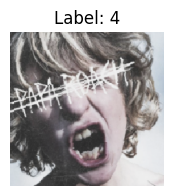

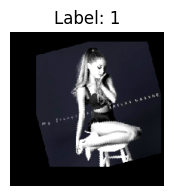

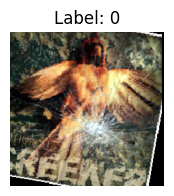

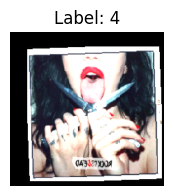

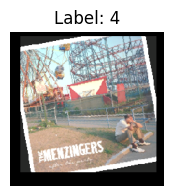

In [14]:
import matplotlib.pyplot as plt

# Get one batch of augmented training images
images, labels = next(iter(train_loader))

# Unnormalize and plot
def imshow(img):
    img = img.permute(1, 2, 0)  # Rearrange dimensions for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    img = img.clip(0, 1)  # Clip values to valid range
    plt.imshow(img)
    plt.axis('off')

# Display the first 5 images in the batch
for i in range(5):
    plt.figure(figsize=(2, 2))
    imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()